# Predicting DG Errors

Through the use of topological indices, we try to predict the errors of DG algorithms. Previously we have already generated the DG errors for our molecules, and saved them in $\texttt{./output/}$

In [31]:
from dg_functions import chemspace_root, chemspace_paths
from indices import all_indices
from dg_processing import LogTransformer, describe_losses, avg_corr, plot_losses_together, feasibility_vector, classification_metrics
from dg_processing import evaluate_classifier, evaluate_classifier_and_get_results, cross_validate_classifier
from dg_processing import nan_columns, constant_columns, collinear_columns

# standard functions for data analysis
import numpy as np, pandas as pd
import pickle
import time, logging
import pprint as pp
from itertools import product
import sklearn

# Chemistry libraries 
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

# plotting
import matplotlib.pyplot as plt
import matplotlib # for LaTeX display
import graphviz

In [2]:
# ignore sklearn warnings for now
import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_colwidth', -1)

In [3]:
logging.basicConfig(filename='logs/dg-error-prediction-all-descs.log',
                    level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s: %(message)s')

In [4]:
chemspace_names = ['c5h6', 'c6h6', '125_56k', '125_338k']

# Loading Chemical Spaces

In [5]:
chemspace = {}
for name in chemspace_names:
    chemspace[name] = {'mols': Chem.SmilesMolSupplier(chemspace_paths[name], delimiter='\t')}

# Loading Conformation / Indices Data

The conformations (from DG) and topological indices of the molecules has been calculated, we load them up:

In [6]:
losses_names = ['length_loss', 'angle_loss', 'energy_loss']
for name in chemspace_names:
    # unpickle the saved indices and conformation data
    with open(f'./output/descriptors_and_maccs/{name}_descriptors', 'rb') as f:        
        feature_names, features, invalids = pickle.load(f)
        chemspace[name]['features'] = pd.DataFrame(features[:, 1:], 
                                                   index=features[:, 0], columns=feature_names)
        
    with open(f'./output/avg_distance_error_bonds_avg_angle_error_by_degree_uff/{name}', 'rb') as f:
        losses, reading_failed, conformation_failed = pickle.load(f)
        chemspace[name]['dg_loss'] = losses
        chemspace[name]['failed_conformation'] = conformation_failed
        
    # molecules that either could not be read when computing indices, or in conformations
    chemspace[name]['invalid'] = list(set().union(invalids, reading_failed))
    
    # Form the losses datafame (with values np.nan or the loss for every molecule)
    df_losses = pd.DataFrame(chemspace[name]['dg_loss'][:, 1:], 
                             index=chemspace[name]['dg_loss'][:, 0], columns=losses_names)
    df_failures = pd.DataFrame(np.nan, index=set().union(chemspace[name]['failed_conformation'], chemspace[name]['invalid']),
                               columns=losses_names)
    chemspace[name]['dg_loss'] = pd.concat([df_losses, df_failures], axis=0).sort_index()
    
    # clear out memory
    del chemspace[name]['failed_conformation']
    del chemspace[name]['invalid']

print(f'{len(feature_names)} features are included, here are the first few: ')
print(feature_names[:10]) 

570 features are included, here are the first few: 
['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons']


## Cleanup of columns

In [7]:
print('Clean-up of features:')
# Find indices to remove using the smaller df (faster execution)
features = chemspace['125_56k']['features']
indices_to_drop = {}

# Some of the input data gives NaNs, we will need to remove these:
cols_with_nan = nan_columns(features)
features.drop(cols_with_nan, axis=1, inplace=True)
indices_to_drop['nan values'] = cols_with_nan

# Find constant entries
constant_cols = constant_columns(features)
features.drop(constant_cols, axis=1, inplace=True)
indices_to_drop['all constant'] = constant_cols

# Remove collinear indices
collinear_cols = collinear_columns(features)
features.drop(collinear_cols, axis=1, inplace=True)
indices_to_drop['high correlation'] = collinear_cols

for reason, indices in indices_to_drop.items():
    print(f'{len(indices)} indices dropped due to {reason}: {indices}')

# free up memory
#del chemspace['125_56k']['features']

all_indices_to_drop = [index for index_list in indices_to_drop.values() for index in index_list]
chemspace['125_338k']['features'].drop(all_indices_to_drop, axis=1, inplace=True)

# missed out additional columns with NaN valuesnot present in '125_56k'
extra_nan_cols = nan_columns(chemspace['125_338k']['features'])
all_indices_to_drop += extra_nan_cols
chemspace['125_338k']['features'].drop(extra_nan_cols, axis=1, inplace=True)
print(f'Additional {len(extra_nan_cols)} columns dropped due to nan values: {extra_nan_cols[:10]}')

Clean-up of features:
68 indices dropped due to nan values: ['AUTOCORR2D_136', 'AUTOCORR2D_137', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'AUTOCORR2D_144', 'AUTOCORR2D_145', 'AUTOCORR2D_146', 'AUTOCORR2D_147', 'AUTOCORR2D_152', 'AUTOCORR2D_153', 'AUTOCORR2D_154', 'AUTOCORR2D_155', 'AUTOCORR2D_148', 'AUTOCORR2D_156', 'AUTOCORR2D_149', 'AUTOCORR2D_157', 'AUTOCORR2D_160', 'AUTOCORR2D_161', 'AUTOCORR2D_162', 'AUTOCORR2D_163', 'AUTOCORR2D_164', 'AUTOCORR2D_165', 'AUTOCORR2D_168', 'AUTOCORR2D_169', 'AUTOCORR2D_170', 'AUTOCORR2D_171', 'AUTOCORR2D_172', 'AUTOCORR2D_173', 'AUTOCORR2D_176', 'AUTOCORR2D_177', 'AUTOCORR2D_178', 'AUTOCORR2D_179', 'AUTOCORR2D_180', 'AUTOCORR2D_181', 'AUTOCORR2D_184', 'AUTOCORR2D_185', 'AUTOCORR2D_96', 'AUTOCORR2D_97', 'AUTOCORR2D_98', 'AUTOCORR2D_99', 'AUTOCORR2D_100', 'AUTOCORR2D_101', 'AUTOCORR2D_104', 'AUTOCORR2D_105', 'AUTOCORR2D_106', 'AUTOCORR2D_107', 'AUTOCORR2D_108', 'AUTOCORR2D_109', 'AUTOCORR2D_112', 'AUTOCORR2D

## Load Trained Models

In [10]:
# Form training set
indices = chemspace['125_338k']['features'].columns

features_scaler = sklearn.preprocessing.StandardScaler()
X = features_scaler.fit_transform(chemspace['125_338k']['features'])

In [11]:
def prepare_training_data(chemspace_name, features_scaler=features_scaler):
    y = {}
    for loss_name, cutoff in zip(['length_loss', 'angle_loss', 'energy_loss'], 
                                 [0.011, 1.530, 10.557]):
        y[loss_name] = feasibility_vector(chemspace[chemspace_name]['dg_loss'][loss_name], cutoff, loss_name)
        print(f'{loss_name} targets successfully computed.', '\n')

    # Transforming features: standardize to mean 0 and variance 1
    X = features_scaler.transform(chemspace[chemspace_name]['features'][indices])
    print('Features successfully computed', '\n')
    
    return X, y

In [12]:
models = {}
for model_type, loss_type in product(['nn', 'hgb'], ['length', 'angle', 'energy']):
    with open(f'./model_gridsearch/{loss_type}/{model_type}', 'rb') as f:
        key = f'{model_type}_{loss_type}'
        models[key] = pickle.load(f).best_estimator_
        print(f'{key} loaded')

nn_length loaded
nn_angle loaded
nn_energy loaded
hgb_length loaded
hgb_angle loaded
hgb_energy loaded


# Generalting Chemical Space Via Topological Indices & Predictors

In [13]:
# Make predictions based on predictor
def predict_feasible_ids(clf, features):
    '''
    Outputs a list of ids for feasbile molecules in `features`
    Input: 
        clf: classifier, giving out 1 / 0 for DG failure / not failure
        data: dataframe with computed topological indices
    '''
    # Drop the indices decided upon during data processing    
    X = features_scaler.transform(features[indices].values)
    feasible = clf.predict(X)
    print(np.count_nonzero(feasible), '/', len(feasible))
    
    return np.argwhere(feasible)

In [14]:
def select_molecules_by(clf, database, actuals=None, size=5*6):
    '''
    Return a selection of chosen molecules as deemed feasible by `clf` in `database`.
    Input:
        clf: classifier, giving 1/0 output for DG failure / success
        database: dictionary with entry
                    `features`, for dataframe with computed topological indices 
                    `mols`, an RDKit molecule feeder object
        actuals: actual feasibility values
        size: number of molecules to select
    '''
    # select feasible molecules
    t0 = time.time()
    feasible_ids = predict_feasible_ids(clf, database['features']).flatten()
    t1 = time.time()
    print(f'Feasbile molecules chosen. Time taken = {t1-t0}')
    
    # actual 'correct' answers are supplied
    y_pred = np.zeros(len(database['features'].index))
    y_pred[feasible_ids] = 1
    if actuals is not None:
        for name, metric in classification_metrics.items():
            loss = metric(y_pred, actuals)
            print(f'{name} = {loss}')
    
    # Choose some random molecules and draw them
    ids_selection = np.random.choice(feasible_ids, size=size, replace=False)
    selected_molecules = [database['mols'][int(i)] for i in ids_selection]
    
    return selected_molecules

9889 / 56225
Feasbile molecules chosen. Time taken = 0.5232536792755127


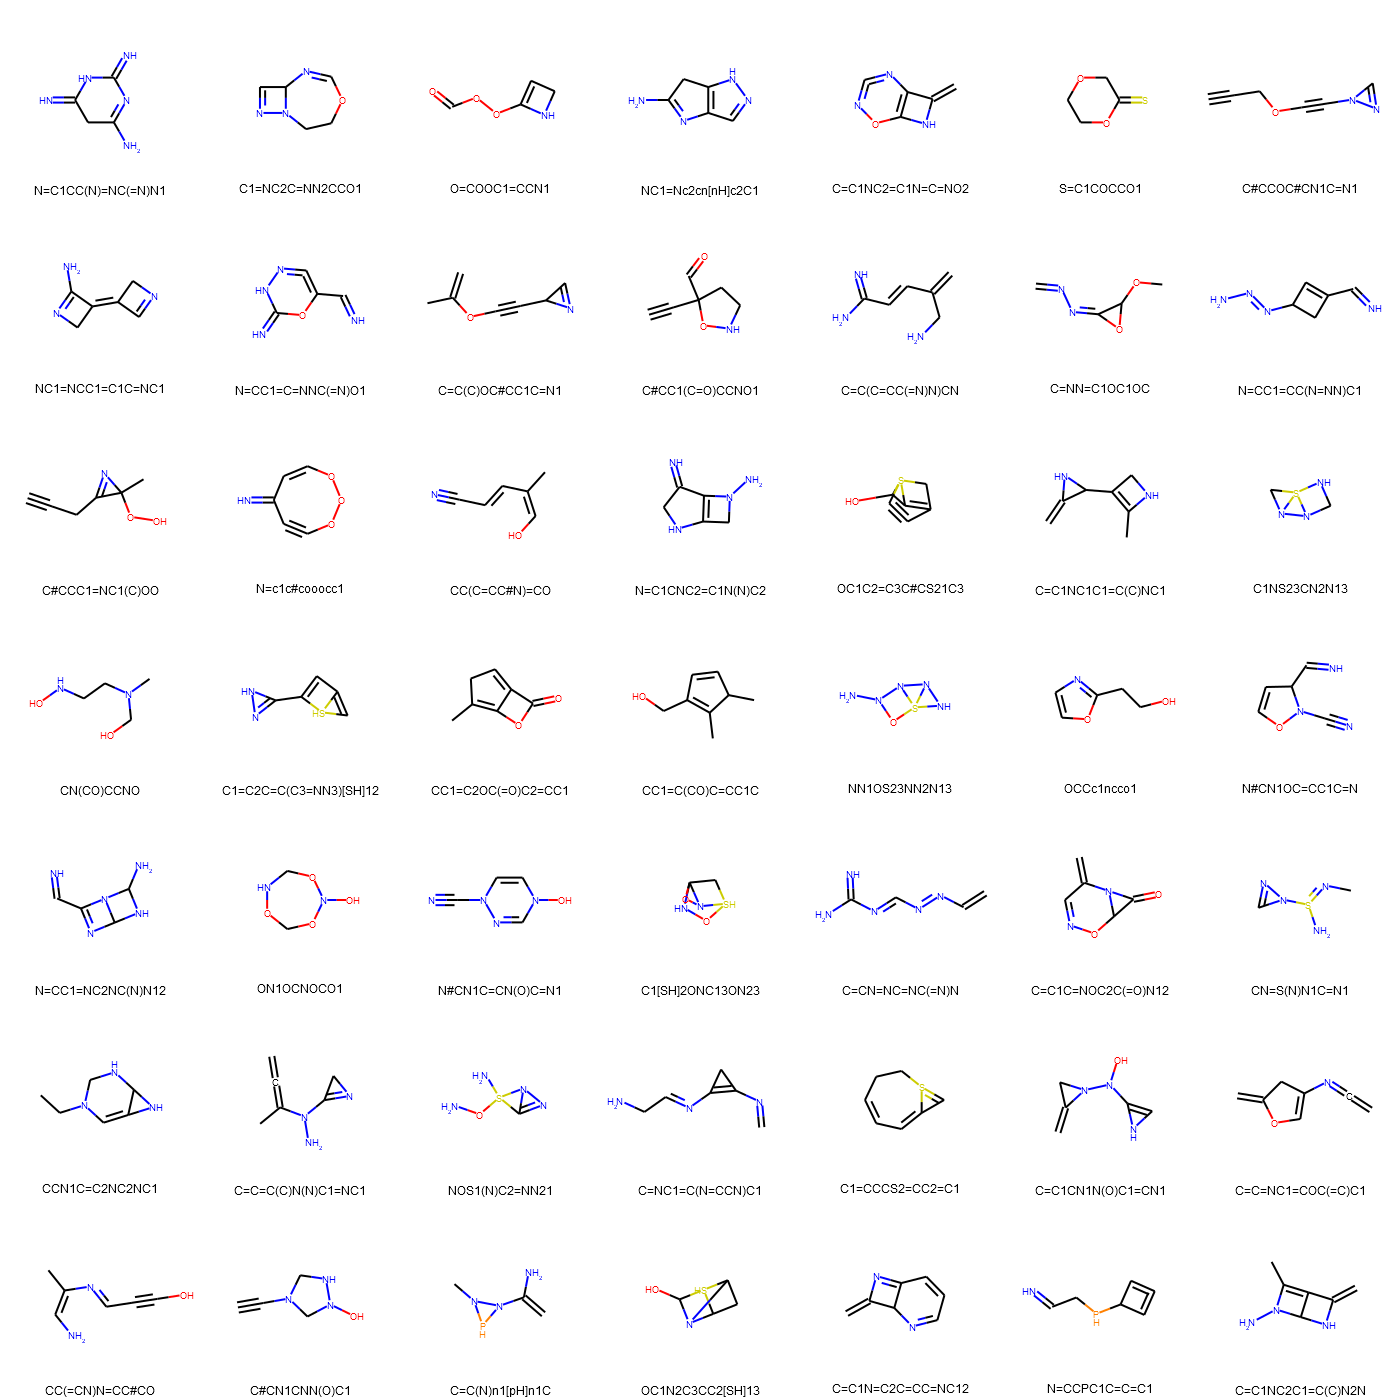

In [15]:
# Molecules chosen by NN
selected_molecules = select_molecules_by(models['nn_energy'], chemspace['125_56k'], size=7*7)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=7, 
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/nn_mols_by_energy.pdf')
img

50 / 216
Feasbile molecules chosen. Time taken = 0.00600123405456543
accuracy = 0.9537037037037037
adjusted balanced accuracy = 0.8838554216867469
balanced accuracy = 0.9419277108433735
average precision = 0.8323646723646724
f1 score = 0.9019607843137256
precision = 0.8846153846153846
recall = 0.92
roc = 0.9419277108433735
confusion matrix
 = [[160   6]
 [  4  46]]


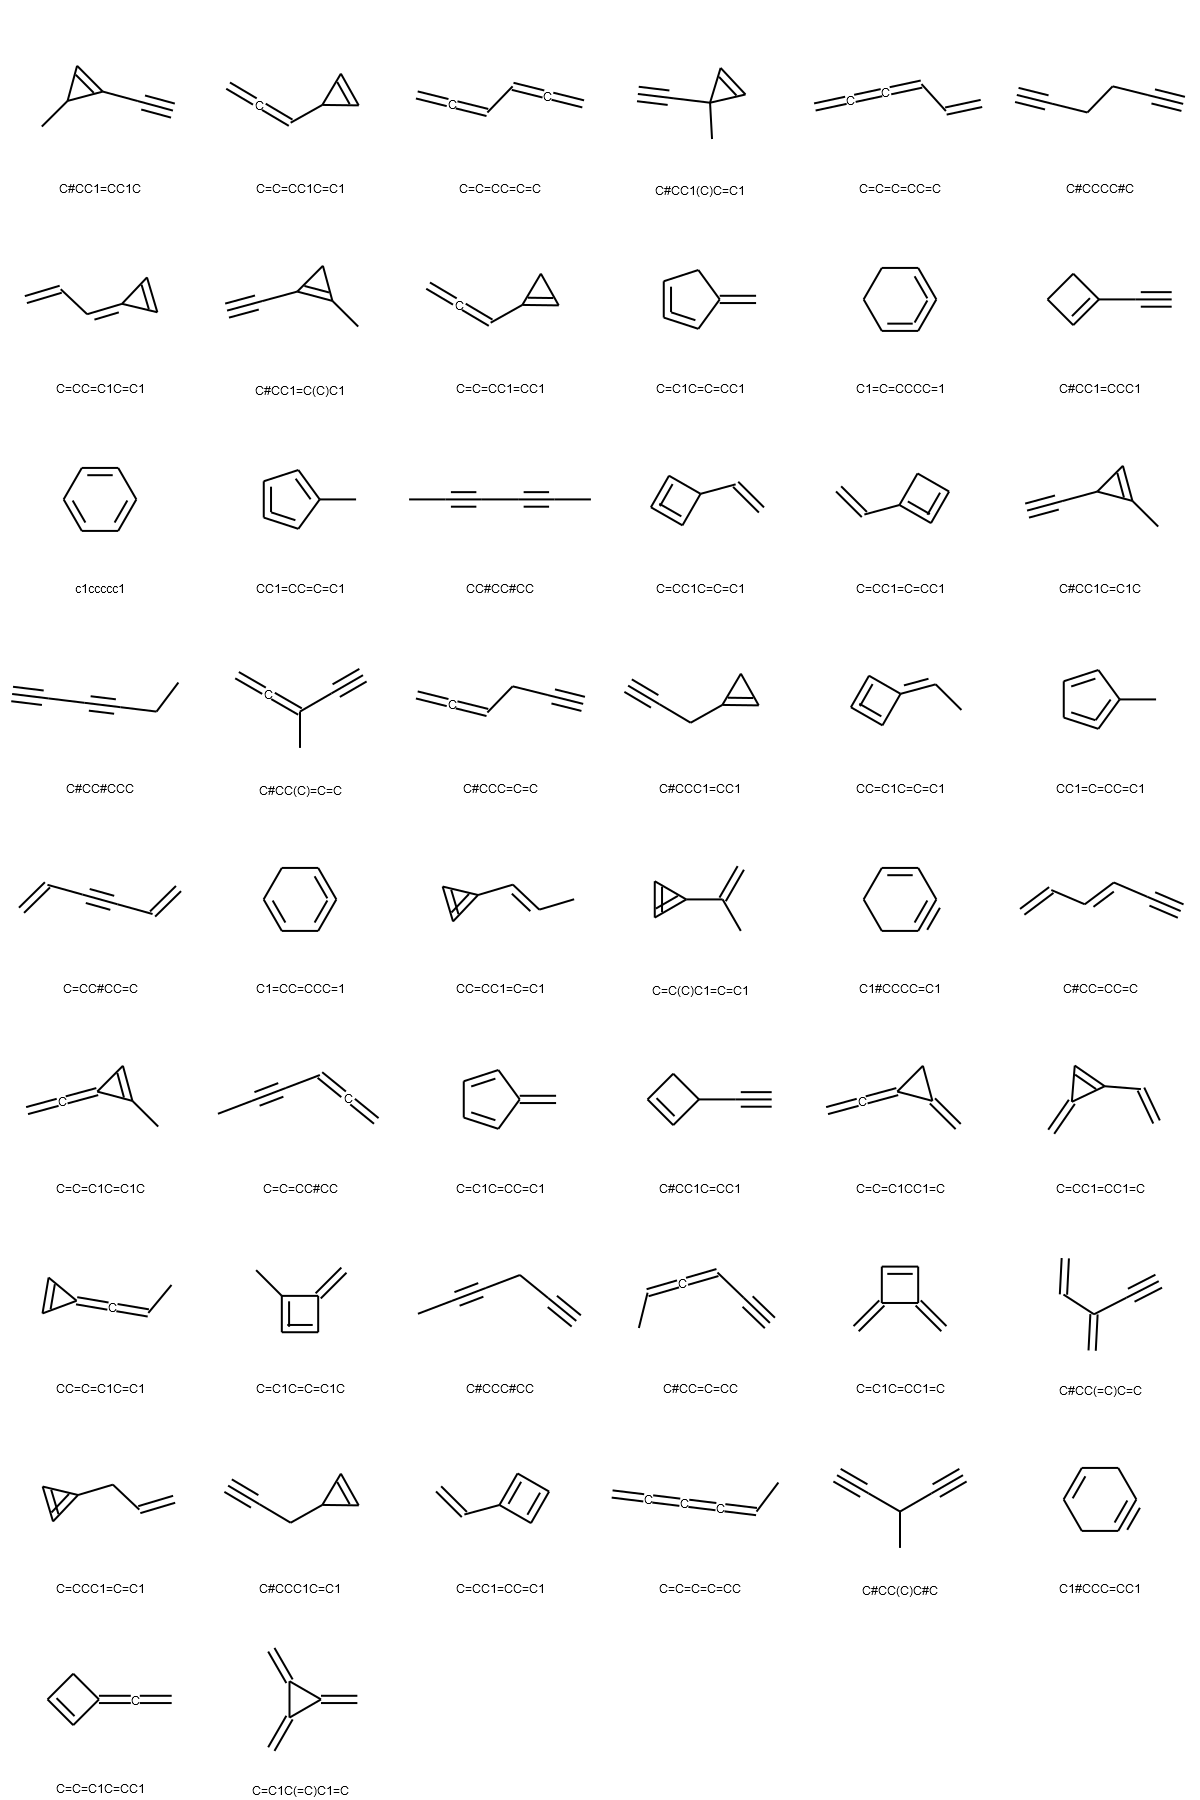

In [115]:
# Molecules chosen by NN
selected_molecules = select_molecules_by(models['nn_energy'], chemspace['c6h6'], actuals=y_c6h6['energy_loss'], size=50)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c6h6_nn_energy.pdf')
img

51 / 216
Feasbile molecules chosen. Time taken = 0.0769956111907959
accuracy = 0.9398148148148148
adjusted balanced accuracy = 0.8399286987522281
balanced accuracy = 0.919964349376114
average precision = 0.791352438411262
f1 score = 0.8737864077669903
precision = 0.8653846153846154
recall = 0.8823529411764706
roc = 0.9199643493761139
confusion matrix
 = [[158   7]
 [  6  45]]


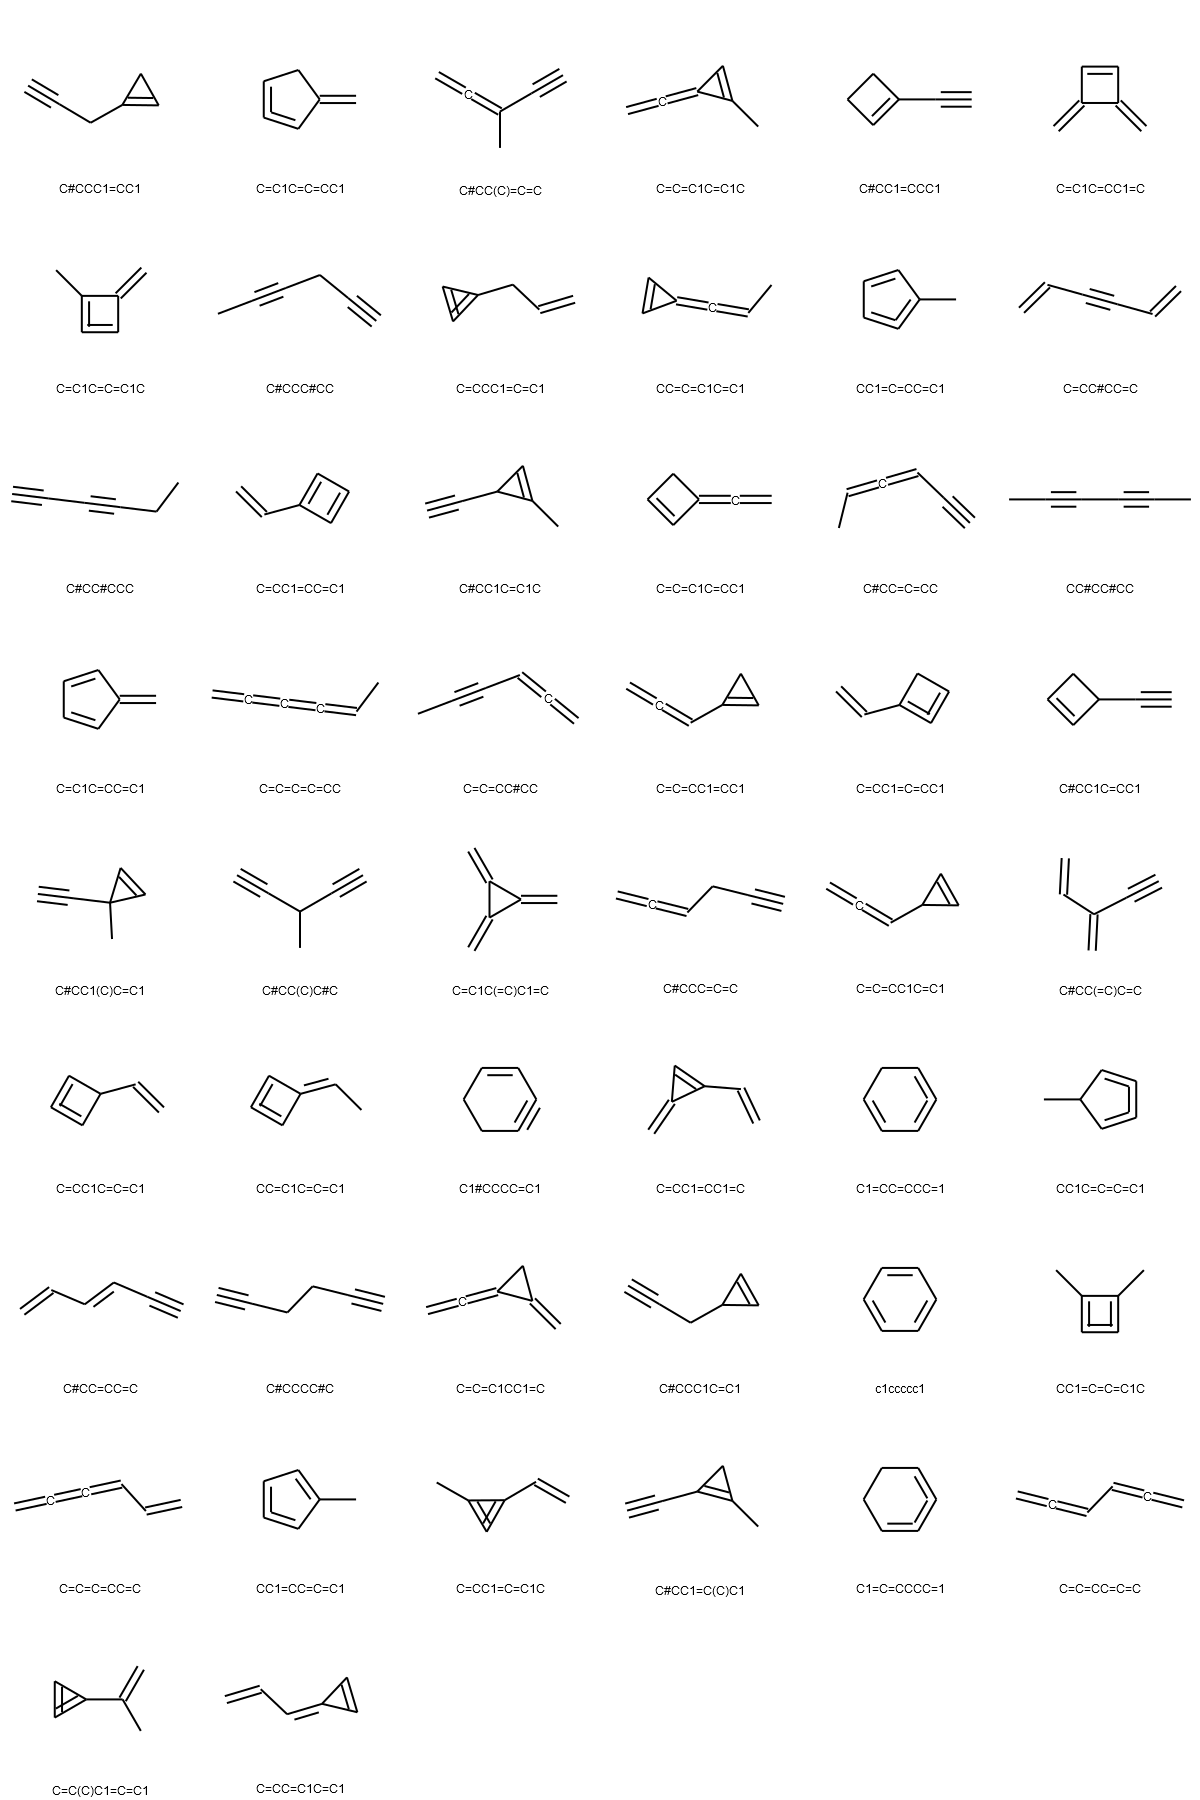

In [116]:
###### Molecules chosen by NN
selected_molecules = select_molecules_by(models['hgb_energy'], chemspace['c6h6'], actuals=y_c6h6['energy_loss'], size=51)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c6h6_hgb_energy.pdf')
img

Taking length_loss of >= 0.011 as 'impossible'
Unconstructible molecules:
6 / 39
length_loss targets successfully computed. 

Taking angle_loss of >= 1.53 as 'impossible'
Unconstructible molecules:
31 / 39
angle_loss targets successfully computed. 

Taking energy_loss of >= 10.557 as 'impossible'
Unconstructible molecules:
24 / 39
energy_loss targets successfully computed. 

Features successfully computed 

15 / 39
Feasbile molecules chosen. Time taken = 0.004999876022338867
accuracy = 0.8974358974358975
adjusted balanced accuracy = 0.7833333333333332
balanced accuracy = 0.8916666666666666
average precision = 0.8023931623931625
f1 score = 0.8666666666666667
precision = 0.8666666666666667
recall = 0.8666666666666667
roc = 0.8916666666666666
confusion matrix
 = [[22  2]
 [ 2 13]]


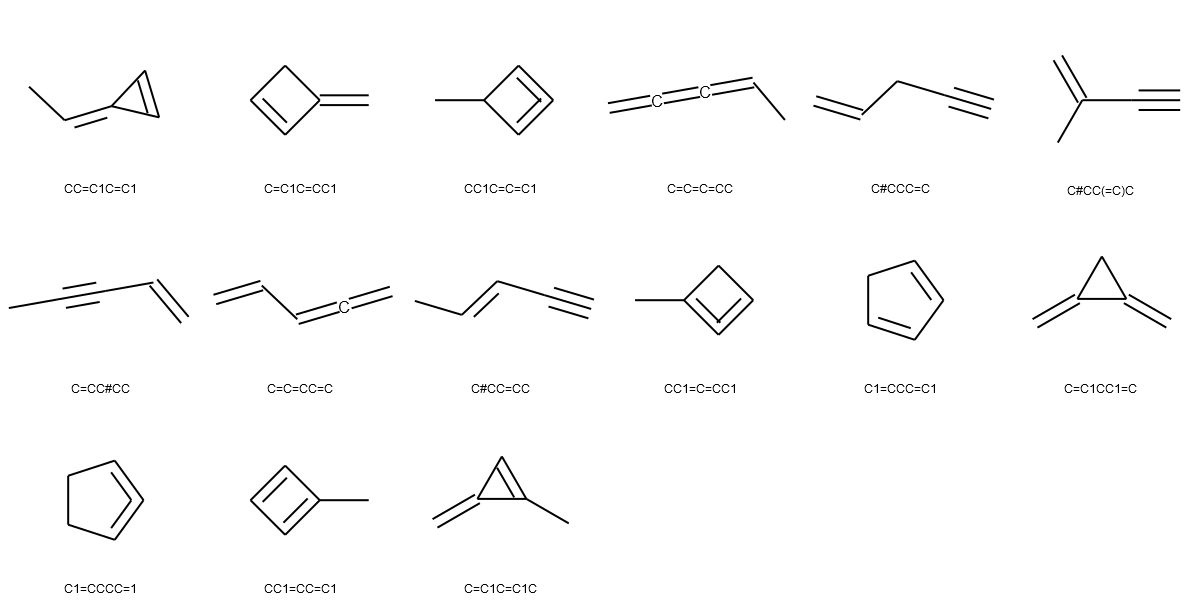

In [30]:
# Molecules chosen by NN
X_c5h6, y_c5h6 = prepare_training_data('c5h6', features_scaler=features_scaler)
selected_molecules = select_molecules_by(models['nn_energy'], chemspace['c5h6'], actuals=y_c5h6['energy_loss'], size=15)
img = Draw.MolsToGridImage(
        selected_molecules, 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=[Chem.MolToSmiles(mol) for mol in selected_molecules])
img.save('./figures/c5h6_nn_energy.pdf')
img

Evaluating models on $C_6H_6$ set

In [17]:
X_c6h6, y_c6h6 = prepare_training_data('c6h6', features_scaler=features_scaler)

Taking length_loss of >= 0.011 as 'impossible'
Unconstructible molecules:
66 / 216
length_loss targets successfully computed. 

Taking angle_loss of >= 1.53 as 'impossible'
Unconstructible molecules:
198 / 216
angle_loss targets successfully computed. 

Taking energy_loss of >= 10.557 as 'impossible'
Unconstructible molecules:
163 / 216
energy_loss targets successfully computed. 

Features successfully computed 



In [22]:
for model_loss_type, model in models.items():
    print(f'Evaluating: {model_loss_type}')
    model_type, loss_type = model_loss_type.split('_')
    evaluate_classifier(model, X_c6h6, y_c6h6[f'{loss_type}_loss'])
    print()

Evaluating: nn_length
Testing results:
accuracy = 0.9629629629629629
adjusted balanced accuracy = 0.8787878787878789
balanced accuracy = 0.9393939393939394
average precision = 0.9493670886075949
f1 score = 0.974025974025974
precision = 0.9493670886075949
recall = 1.0
roc = 0.9393939393939394
confusion matrix
 = [[ 58   8]
 [  0 150]]

Evaluating: nn_angle
Testing results:
accuracy = 0.9444444444444444
adjusted balanced accuracy = 0.43434343434343425
balanced accuracy = 0.7171717171717171
average precision = 0.40185185185185185
f1 score = 0.5714285714285714
precision = 0.8
recall = 0.4444444444444444
roc = 0.7171717171717172
confusion matrix
 = [[196   2]
 [ 10   8]]

Evaluating: nn_energy
Testing results:
accuracy = 0.9537037037037037
adjusted balanced accuracy = 0.8240537099201297
balanced accuracy = 0.9120268549600649
average precision = 0.8534067085953878
f1 score = 0.8979591836734695
precision = 0.9777777777777777
recall = 0.8301886792452831
roc = 0.9120268549600649
confusion matri

Proportion of $C_6H_6$ in the training set

In [27]:
c6h6_count = 0
c5h6_count = 0
for mol in chemspace['125_338k']['mols']:
    formula = Chem.rdMolDescriptors.CalcMolFormula(mol)
    if formula == 'C6H6':
        c6h6_count += 1
        print(f'C6H6 isomer: {Chem.MolToSmiles(mol)}')
    elif formula == 'C5H6':
        c5h6_count += 1
        print(f'C5H6 isomer: {Chem.MolToSmiles(mol)}')
print(f'Total of {c6h6_count} C6H6 isomers; {c5h6_count} C5H6 isomers in training/testing set')

C6H6 isomer: C=C=CC1=CC1
Total of 1 C6H6 isomers; 0 C5H6 isomers in training/testing set


In [44]:
# [1, 1, 1] propellane - why is it missing?!!?
Chem.CanonSmiles('C1(C2)(C3)C23C1')

'C1C23CC12C3'

$C_6H_6$ Isomers Energy vs. Predictions

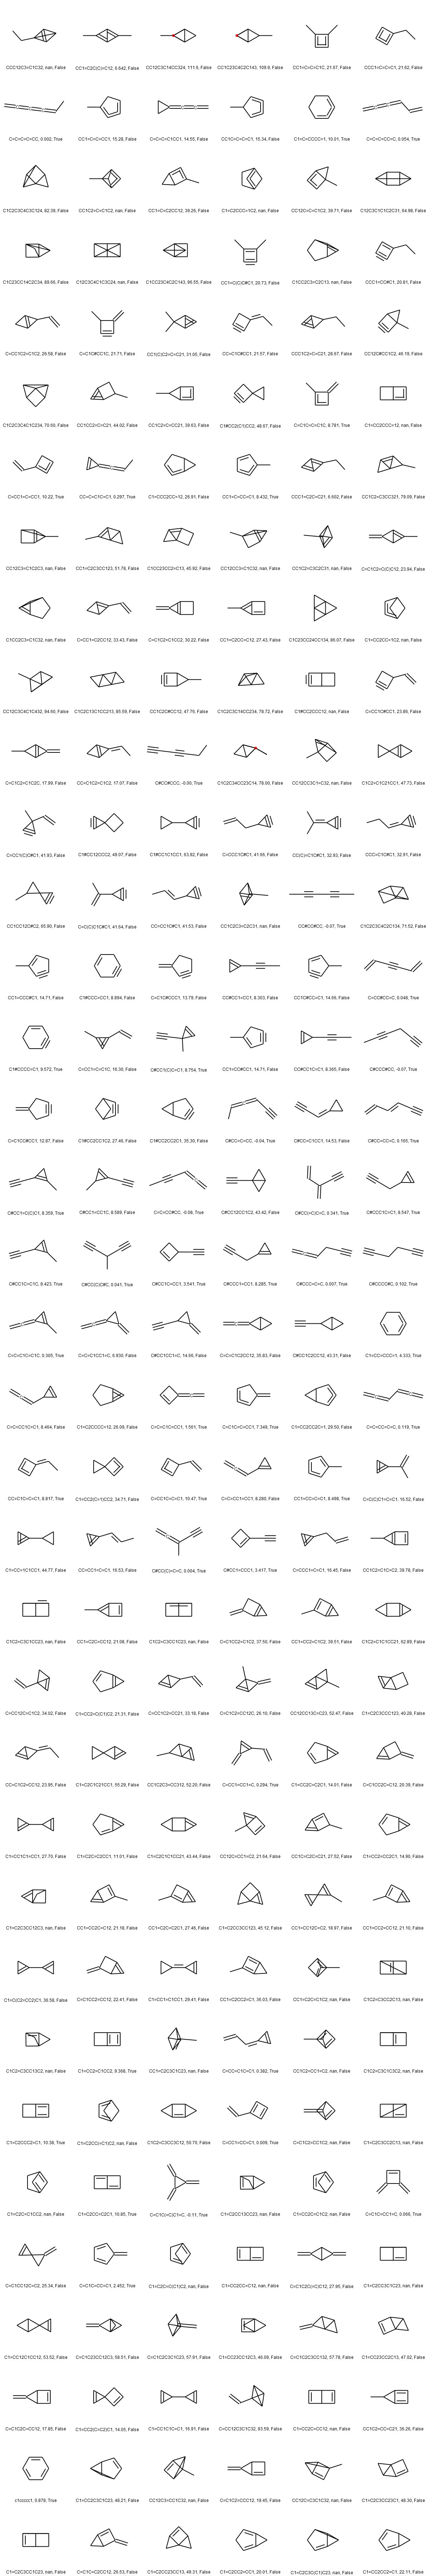

In [23]:
c6h6s = [mol for mol in chemspace['c6h6']['mols']]
c6h6_losses = chemspace['c6h6']['dg_loss']['energy_loss']
c6h6_predictions = models['nn_energy'].predict(X_c6h6)
c6h6_legends = [f'{Chem.MolToSmiles(mol)}, {str(loss)[:5]}, {pred}' 
                for mol, loss, pred in zip(c6h6s, c6h6_losses, c6h6_predictions)]

img = Draw.MolsToGridImage(
        [mol for mol in chemspace['c6h6']['mols']], 
        molsPerRow=6,
        subImgSize=(200,200),
        legends=c6h6_legends,
        maxMols=216)
img.save('./figures/c6h6_all_predictions.pdf')
img

### Known isomers that failed DG

In [35]:
from dg_functions import mols_dg_errors

In [39]:
mols = {
    'Dewar Benzene': "C1=CC2C=CC12",
    'Bicyclopropenyl': "C1=CC1C1C=C1",
    'Prismane': "C12C3C1C1C2C31"
}

for name, smiles in mols.items():
    print(f'Evaluating: {name}')
    m = Chem.MolFromSmiles(smiles)
    mols_dg_errors([m], retry_attempts=10)

    m_with_h = Chem.AddHs(m)
    failure = 'failed' if AllChem.EmbedMolecule(m_with_h) == -1 else 'succeded'
    print(f'{name} has {failure} ETKDG\n')

Evaluating: Dewar Benzene
Initially: 1/1 molecules failed conformation
Of these, 1/1 still failed after another 10 tries.
Dewar Benzene has failed ETKDG

Evaluating: Bicyclopropenyl
Initially: 0/1 molecules failed conformation
Of these, 0/0 still failed after another 10 tries.
Bicyclopropenyl has succeded ETKDG

Evaluating: Prismane
Initially: 0/1 molecules failed conformation
Of these, 0/0 still failed after another 10 tries.
Prismane has succeded ETKDG



-1
